<a href="https://colab.research.google.com/github/TechTrailblazer22/Advanced-AI-Chatbot---SOC-2024/blob/main/SOC_Time_Series_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Performing ADF Test on Original Data...
ADF Statistic: 0.5571796813759831
p-value: 0.9865112232773973
Critical Values:
	1%: -3.4356863371792095
	5%: -2.8638964938393667
	10%: -2.568024631481501
The time series is not stationary. Applying differencing...
Performing ADF Test on Differenced Data...
ADF Statistic: -14.29866912788924
p-value: 1.2398146834930455e-26
Critical Values:
	1%: -3.4356863371792095
	5%: -2.8638964938393667
	10%: -2.568024631481501
The time series is stationary after differencing.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2953.814, Time=5.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2959.068, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2960.919, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2960.917, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2964.845, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2963.678, Time=0.64 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2955.183, Time

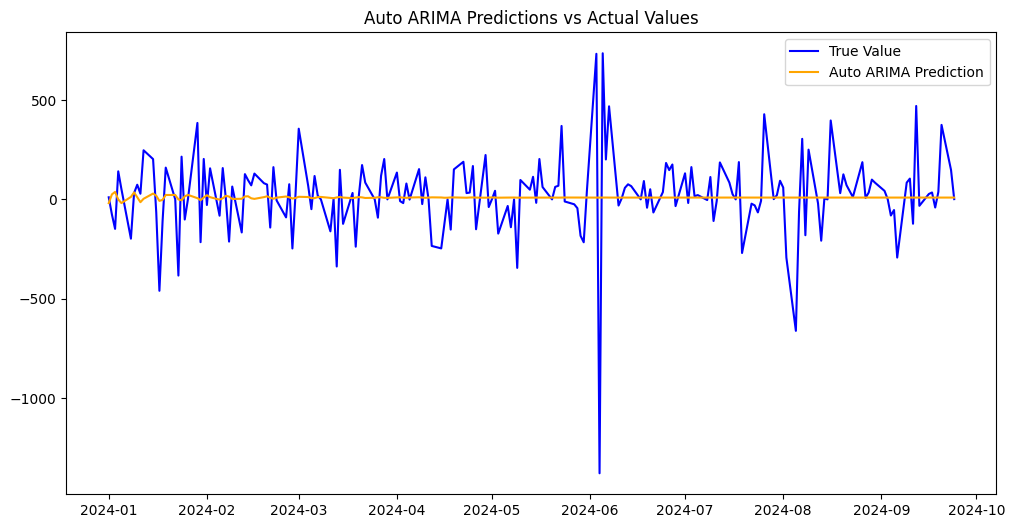

SARIMA (Corrected) - MAE: 145.60, RMSE: 218.10


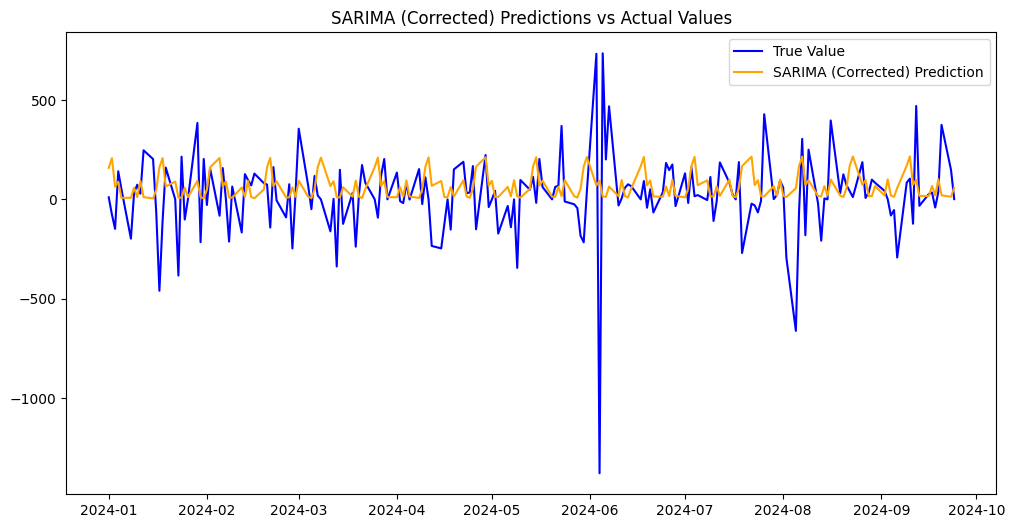

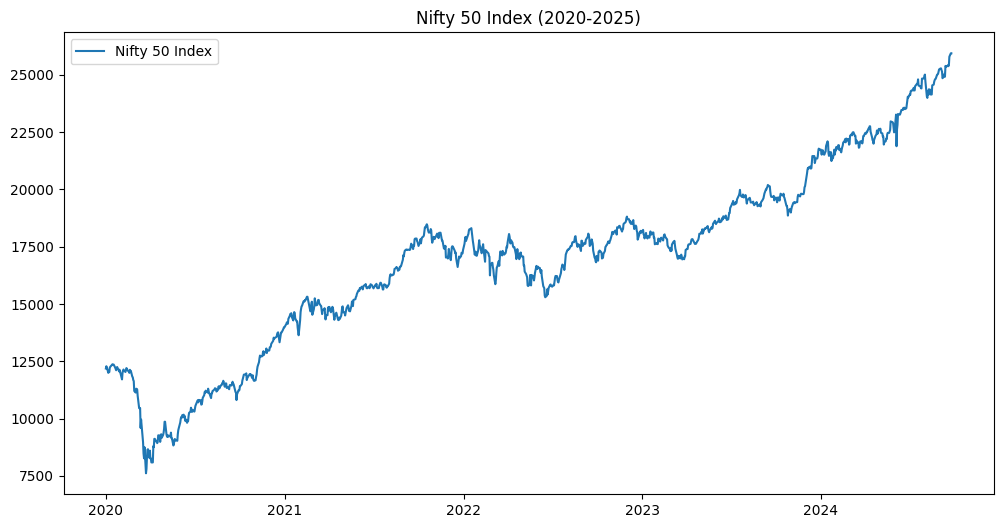

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Step 1: Download Nifty-50 Data (2020 to 2025)
def download_nifty50_data():
    nifty50 = yf.download('^NSEI', start='2020-01-01', end='2025-01-01')
    return nifty50['Close']

nifty50_data = download_nifty50_data()
nifty50_data = nifty50_data.asfreq('B').fillna(method='ffill')

# Step 2: Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] <= 0.05  # p-value <= 0.05 indicates stationarity

print("Performing ADF Test on Original Data...")
is_stationary = check_stationarity(nifty50_data)

# Step 3: Differencing
if not is_stationary:
    print("The time series is not stationary. Applying differencing...")
    nifty50_diff = nifty50_data.diff().dropna()

    # Step 4: Perform ADF Test after Differencing
    print("Performing ADF Test on Differenced Data...")
    is_stationary_diff = check_stationarity(nifty50_diff)

    if is_stationary_diff:
        print("The time series is stationary after differencing.")
    else:
        print("The time series is still not stationary. Further transformations may be required.")
else:
    nifty50_diff = nifty50_data  # No differencing needed
    print("The time series is stationary without differencing.")

# Step 5: Split the Data
train_data = nifty50_diff[:'2023-12-31']
test_data = nifty50_diff['2024-01-01':]

# Step 6: Scaling the Data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Step 7: Apply Auto ARIMA
model_auto_arima = auto_arima(
    train_data_scaled,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    max_p=5, max_q=5, max_d=2,
    max_order=None
)

n_periods = len(test_data)
forecast_scaled_auto_arima, conf_int = model_auto_arima.predict(n_periods=n_periods, return_conf_int=True)

# Step 8: Inverse Transform Auto ARIMA Forecasts
predictions_auto_arima = scaler.inverse_transform(forecast_scaled_auto_arima.reshape(-1, 1)).flatten()

# Step 9: Apply SARIMA
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
forecast_sarima = sarima_fit.forecast(steps=n_periods)

# Apply correction factor for SARIMA
correction_factor = 4
forecast_sarima_adjusted = forecast_sarima * correction_factor

# Step 10: Evaluate and Plot
def evaluate_and_plot(true_values, predictions, model_name):
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(true_values.index, true_values, label='True Value', color='blue')
    plt.plot(true_values.index, predictions, label=f'{model_name} Prediction', color='orange')
    plt.title(f'{model_name} Predictions vs Actual Values')
    plt.legend()
    plt.show()

# Evaluate and plot both models
evaluate_and_plot(test_data, predictions_auto_arima, 'Auto ARIMA')
evaluate_and_plot(test_data, forecast_sarima_adjusted, 'SARIMA (Corrected)')

# Plot the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(nifty50_data.index, nifty50_data, label='Nifty 50 Index')
plt.title('Nifty 50 Index (2020-2025)')
plt.legend()
plt.show()
